In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Importing the modules themselves for reloading
import TradePosition
import TouchArea
import TradingStrategy
import TouchDetection

# Reloading the modules to apply any changes
import importlib
importlib.reload(TradePosition)
importlib.reload(TouchArea)
importlib.reload(TradingStrategy)
importlib.reload(TouchDetection)

from TradePosition import TradePosition
from TouchArea import TouchArea
from TradingStrategy import StrategyParameters, TouchDetectionAreas, TradingStrategy 

from TouchDetection import TouchDetectionParameters, calculate_touch_detection_area, plot_touch_detection_areas

In [2]:
# symbol = "NVDA"
symbol = "MSFT"
# symbol = "AAPL" #
# symbol = "TJX"
# symbol = "JNJ" #
# symbol = "AMZN"
# symbol = "AZN"
# symbol = "TSLA" #
# symbol = "TJX" #


# start_date = "2023-01-01 00:00:00"
# end_date =   "2024-01-01 00:00:00"

start_date = "2024-01-01 00:00:00"
end_date =   "2024-08-17 00:00:00"

# Usage example:
touch_params = TouchDetectionParameters(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    atr_period=15,
    level1_period=15,
    multiplier=1.4,
    min_touches=3,
    start_time=None,
    end_time='16:00',
    use_median=True,
    touch_area_width_agg=np.median,
    use_saved_bars=True,
    rolling_avg_decay_rate=0.85
    # export_bars_path=f'bars/bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
)

# touch_detection_areas = calculate_touch_detection_area(touch_params)

# touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, level1_period=15, multiplier=1.4, min_touches=3, start_time=None, end_time='16:00', \
#     use_median=True, touch_area_width_agg=np.median, use_saved_bars=True, export_bars_path=f'bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv')


In [3]:
# a = touch_detection_areas['bars'][touch_detection_areas['mask']]['trade_count'].astype(float).describe()
# b = touch_detection_areas['bars'][touch_detection_areas['mask']]['volume'].astype(float).describe()
# c = touch_detection_areas['bars'][touch_detection_areas['mask']]['shares_per_trade'].astype(float).describe()
# pd.concat([a,b,c],axis=1)

In [4]:
zoom_start_date = start_date
zoom_end_date = end_date
# zoom_start_date = "2023-05-26 12:00:00"
# zoom_end_date = "2023-05-26 12:40:00"
# plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date)

In [5]:
# len(touch_detection_areas['long_touch_area']) + len(touch_detection_areas['short_touch_area'])

In [6]:
params = StrategyParameters(
    initial_investment=10_000,
    do_longs=True,
    do_shorts=True,
    sim_longs=True,
    sim_shorts=True,
    
    use_margin=True,
    
    times_buying_power=1,
    
    soft_start_time = None, 
    soft_end_time = '15:50',
    
    # slippage_factor=0
)

# strategy = TradingStrategy(TouchDetectionAreas.from_dict(touch_detection_areas), params, export_trades_path='trades_output.csv')
# results = strategy.run_backtest()

In [1]:
# symbols = ['AAPL','INTC','JNJ','TSLA','MSFT','AMZN','ABBV']
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
# symbols = ['NVDA', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
# symbols = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'BAC', 'META', 'T', 'VZ', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # generally high-liquidity from 2016 to present
symbols = ['AAPL', 'MSFT', 'NVDA', 'INTC', 'AMZN', 'TSLA', 'DIS', 'JPM', 'BAC', 'GOOGL', 'FB', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # test3. generally high-liquidity from 2016 to 2019

['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'BAC', 'META', 'T', 'VZ', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO']


In [8]:
trades_folder = 'test2/trades'
graphs_folder = 'test2/graphs'
xbp_folder = 'test2/xbp'

from IPython.utils import io
for s in symbols:
    touch_params.symbol = s
    touch_params.export_bars_path=f'bars/bars_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    
    # print(touch_params.symbol)
    # print(touch_params.export_bars_path)
    results_list = []
    
    # print(touch_params)
    touch_detection_areas = calculate_touch_detection_area(touch_params)
    # continue
    for i in tqdm(list(np.arange(0.5, 4.01, 0.5))):
        
        params.times_buying_power = i
        with io.capture_output() as captured:
            strategy = TradingStrategy(TouchDetectionAreas.from_dict(touch_detection_areas), params)
            
            if i == 1:
                strategy.export_trades_path=f'{trades_folder}/trades_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
                strategy.export_graph_path=f'{graphs_folder}/graph_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.png'
            
            balance, longs_executed, shorts_executed, balance_change, mean_profit_loss_pct, win_mean_profit_loss_pct, lose_mean_profit_loss_pct, winrate, total_costs, \
                avg_sub_pos, avg_transact, count_entry_adjust, count_entry_skip, count_exit_adjust, count_exit_skip, key_stats = \
                strategy.run_backtest()

        trades_executed = longs_executed + shorts_executed
        newrow = {
            'xBP': i,
            'net%': balance_change,
            'balance': balance,
            'cnt': trades_executed,
            # 'AvgPL%': mean_profit_loss_pct,
            # 'winAvgPL%': win_mean_profit_loss_pct,
            # 'loseAvgPL%': lose_mean_profit_loss_pct,
            'WR%': winrate,
            'TotalCosts': total_costs,
            # 'avg sub pos created': avg_sub_pos,
            # 'avg transactions': avg_transact,
            'entryAdjust': count_entry_adjust,
            'entrySkip': count_entry_skip,
            'exitAdjust': count_exit_adjust,
            'exitSkip': count_exit_skip,
            **key_stats
        }
        results_list.append(newrow)

    results = pd.DataFrame(results_list)
    # Format specific columns if needed
    results['xBP'] = results['xBP'].map('{:.1f}'.format)
    results['balance'] = results['balance'].map('${:.4f}'.format)
    results['TotalCosts'] = results['TotalCosts'].map('${:.4f}'.format)

    # Format all float columns
    float_columns = results.select_dtypes(include=['float64']).columns
    results[float_columns] = results[float_columns].applymap('{:.4f}'.format)

    # Display the results
    # pd.set_option('display.max_columns', None)
    filename = f'{xbp_folder}/xbp_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    results.to_csv(filename,index=False)
    # results

Retrieved bars from bars/bars_NVDA_2024-01-01_2024-08-17.zip
                                   open   high    low  close   volume  \
symbol timestamp                                                        
NVDA   2024-01-02 04:00:00-05:00  49.37  49.51  49.37  49.47  22950.0   
       2024-01-02 04:01:00-05:00  49.48  49.48  49.48  49.48   7260.0   
       2024-01-02 04:02:00-05:00  49.52  49.52  49.49  49.52  10080.0   
       2024-01-02 04:03:00-05:00  49.52  49.52  49.52  49.52   3250.0   
       2024-01-02 04:04:00-05:00  49.52  49.52  49.52  49.52   3090.0   

                                  trade_count   vwap  
symbol timestamp                                      
NVDA   2024-01-02 04:00:00-05:00        101.0  49.47  
       2024-01-02 04:01:00-05:00         40.0  49.48  
       2024-01-02 04:02:00-05:00         24.0  49.51  
       2024-01-02 04:03:00-05:00         18.0  49.52  
       2024-01-02 04:04:00-05:00         18.0  49.52  


100%|██████████| 8/8 [09:24<00:00, 70.52s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_10348\1834002939.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_JPM_2024-01-01_2024-08-17.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
JPM    2024-01-02 04:03:00-05:00  167.09  167.14  167.09  167.14  1005.0   
       2024-01-02 04:04:00-05:00  167.23  167.23  167.23  167.23   156.0   
       2024-01-02 04:05:00-05:00  167.23  167.23  167.23  167.23     0.0   
       2024-01-02 04:06:00-05:00  167.23  167.23  167.23  167.23     0.0   
       2024-01-02 04:07:00-05:00  167.23  167.23  167.23  167.23     0.0   

                                  trade_count    vwap  
symbol timestamp                                       
JPM    2024-01-02 04:03:00-05:00         37.0  167.12  
       2024-01-02 04:04:00-05:00          4.0  167.22  
       2024-01-02 04:05:00-05:00          0.0     NaN  
       2024-01-02 04:06:00-05:00          0.0     NaN  
       2024-01-02 04:07:00-05:00          0.0     NaN  


100%|██████████| 8/8 [10:33<00:00, 79.21s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_10348\1834002939.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_GOOGL_2024-01-01_2024-08-17.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
GOOGL  2024-01-02 04:00:00-05:00  139.84  139.84  139.83  139.83   905.0   
       2024-01-02 04:01:00-05:00  139.84  139.84  139.83  139.83     0.0   
       2024-01-02 04:02:00-05:00  139.84  139.84  139.83  139.83     0.0   
       2024-01-02 04:03:00-05:00  139.84  139.84  139.83  139.83     0.0   
       2024-01-02 04:04:00-05:00  139.84  139.84  139.83  139.83     0.0   

                                  trade_count    vwap  
symbol timestamp                                       
GOOGL  2024-01-02 04:00:00-05:00         57.0  139.72  
       2024-01-02 04:01:00-05:00          0.0     NaN  
       2024-01-02 04:02:00-05:00          0.0     NaN  
       2024-01-02 04:03:00-05:00          0.0     NaN  
       2024-01-02 04:04:00-05:00          0.0     NaN  


100%|██████████| 8/8 [10:03<00:00, 75.38s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_10348\1834002939.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_META_2024-01-01_2024-08-17.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
META   2024-01-02 04:07:00-05:00  353.37  353.48  353.37  353.48   423.0   
       2024-01-02 04:08:00-05:00  353.48  353.48  353.48  353.48   490.0   
       2024-01-02 04:09:00-05:00  353.48  353.48  353.48  353.48     0.0   
       2024-01-02 04:10:00-05:00  353.48  353.48  353.48  353.48     0.0   
       2024-01-02 04:11:00-05:00  353.48  353.48  353.48  353.48     0.0   

                                  trade_count    vwap  
symbol timestamp                                       
META   2024-01-02 04:07:00-05:00         14.0  353.49  
       2024-01-02 04:08:00-05:00          7.0  353.56  
       2024-01-02 04:09:00-05:00          0.0     NaN  
       2024-01-02 04:10:00-05:00          0.0     NaN  
       2024-01-02 04:11:00-05:00          0.0     NaN  


100%|██████████| 8/8 [07:52<00:00, 59.05s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_10348\1834002939.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_XOM_2024-01-01_2024-08-17.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
XOM    2024-01-02 04:00:00-05:00  98.25  98.25  97.77  97.78  1588.0   
       2024-01-02 04:01:00-05:00  98.40  98.40  98.40  98.40   648.0   
       2024-01-02 04:02:00-05:00  98.40  98.40  98.40  98.40     0.0   
       2024-01-02 04:03:00-05:00  98.47  98.47  98.47  98.47   856.0   
       2024-01-02 04:04:00-05:00  98.38  98.38  98.38  98.38   416.0   

                                  trade_count   vwap  
symbol timestamp                                      
XOM    2024-01-02 04:00:00-05:00         18.0  97.84  
       2024-01-02 04:01:00-05:00         24.0  98.42  
       2024-01-02 04:02:00-05:00          0.0    NaN  
       2024-01-02 04:03:00-05:00          9.0  98.47  
       2024-01-02 04:04:00-05:00         12.0  98.36  


100%|██████████| 8/8 [06:46<00:00, 50.81s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_10348\1834002939.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_CVX_2024-01-01_2024-08-17.zip
                                   open   high     low   close  volume  \
symbol timestamp                                                         
CVX    2024-01-02 04:00:00-05:00  147.0  147.0  146.65  146.65   636.0   
       2024-01-02 04:01:00-05:00  147.0  147.0  146.65  146.65     0.0   
       2024-01-02 04:02:00-05:00  147.0  147.0  146.65  146.65     0.0   
       2024-01-02 04:03:00-05:00  147.0  147.0  146.65  146.65     0.0   
       2024-01-02 04:04:00-05:00  147.0  147.0  146.65  146.65     0.0   

                                  trade_count    vwap  
symbol timestamp                                       
CVX    2024-01-02 04:00:00-05:00         22.0  146.79  
       2024-01-02 04:01:00-05:00          0.0     NaN  
       2024-01-02 04:02:00-05:00          0.0     NaN  
       2024-01-02 04:03:00-05:00          0.0     NaN  
       2024-01-02 04:04:00-05:00          0.0     NaN  


100%|██████████| 8/8 [07:30<00:00, 56.28s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_10348\1834002939.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_UNH_2024-01-01_2024-08-17.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
UNH    2024-01-02 08:00:00-05:00  522.16  522.16  522.16  522.16  1295.0   
       2024-01-02 08:01:00-05:00  522.16  522.16  522.16  522.16     0.0   
       2024-01-02 08:02:00-05:00  522.16  522.16  522.16  522.16     0.0   
       2024-01-02 08:03:00-05:00  522.16  522.16  522.16  522.16     0.0   
       2024-01-02 08:04:00-05:00  522.16  522.16  522.16  522.16     0.0   

                                  trade_count    vwap  
symbol timestamp                                       
UNH    2024-01-02 08:00:00-05:00         18.0  522.12  
       2024-01-02 08:01:00-05:00          0.0     NaN  
       2024-01-02 08:02:00-05:00          0.0     NaN  
       2024-01-02 08:03:00-05:00          0.0     NaN  
       2024-01-02 08:04:00-05:00          0.0     NaN  


100%|██████████| 8/8 [10:01<00:00, 75.24s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_10348\1834002939.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_PFE_2024-01-01_2024-08-17.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
PFE    2024-01-02 04:00:00-05:00  27.61  27.73  27.61  27.73  2892.0   
       2024-01-02 04:01:00-05:00  27.61  27.73  27.61  27.73     0.0   
       2024-01-02 04:02:00-05:00  27.72  27.72  27.72  27.72   200.0   
       2024-01-02 04:03:00-05:00  27.72  27.73  27.72  27.73  2908.0   
       2024-01-02 04:04:00-05:00  27.73  27.73  27.71  27.71  2711.0   

                                  trade_count   vwap  
symbol timestamp                                      
PFE    2024-01-02 04:00:00-05:00         41.0  27.70  
       2024-01-02 04:01:00-05:00          0.0    NaN  
       2024-01-02 04:02:00-05:00          9.0  27.72  
       2024-01-02 04:03:00-05:00         13.0  27.72  
       2024-01-02 04:04:00-05:00         15.0  27.73  


100%|██████████| 8/8 [05:21<00:00, 40.18s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_10348\1834002939.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_KO_2024-01-01_2024-08-17.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
KO     2024-01-02 04:15:00-05:00  58.08  58.08  58.08  58.08   276.0   
       2024-01-02 04:16:00-05:00  58.08  58.08  58.08  58.08     0.0   
       2024-01-02 04:17:00-05:00  58.08  58.08  58.08  58.08     0.0   
       2024-01-02 04:18:00-05:00  58.08  58.08  58.08  58.08     0.0   
       2024-01-02 04:19:00-05:00  58.08  58.08  58.08  58.08     0.0   

                                  trade_count   vwap  
symbol timestamp                                      
KO     2024-01-02 04:15:00-05:00         10.0  58.08  
       2024-01-02 04:16:00-05:00          0.0    NaN  
       2024-01-02 04:17:00-05:00          0.0    NaN  
       2024-01-02 04:18:00-05:00          0.0    NaN  
       2024-01-02 04:19:00-05:00          0.0    NaN  


100%|██████████| 8/8 [06:15<00:00, 46.89s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_10348\1834002939.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_PG_2024-01-01_2024-08-17.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
PG     2024-01-02 06:35:00-05:00  143.47  143.47  143.47  143.47   138.0   
       2024-01-02 06:36:00-05:00  143.47  143.47  143.47  143.47     0.0   
       2024-01-02 06:37:00-05:00  143.64  143.64  143.64  143.64   139.0   
       2024-01-02 06:38:00-05:00  143.64  143.64  143.64  143.64     0.0   
       2024-01-02 06:39:00-05:00  143.64  143.64  143.64  143.64     0.0   

                                  trade_count    vwap  
symbol timestamp                                       
PG     2024-01-02 06:35:00-05:00          2.0  143.47  
       2024-01-02 06:36:00-05:00          0.0     NaN  
       2024-01-02 06:37:00-05:00          3.0  143.63  
       2024-01-02 06:38:00-05:00          0.0     NaN  
       2024-01-02 06:39:00-05:00          0.0     NaN  


100%|██████████| 8/8 [07:51<00:00, 58.89s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_10348\1834002939.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_BA_2024-01-01_2024-08-17.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
BA     2024-01-02 04:38:00-05:00  260.35  260.35  260.10  260.30  2881.0   
       2024-01-02 04:39:00-05:00  260.23  260.23  260.23  260.23   679.0   
       2024-01-02 04:40:00-05:00  260.23  260.23  260.23  260.23     0.0   
       2024-01-02 04:41:00-05:00  260.23  260.23  260.23  260.23     0.0   
       2024-01-02 04:42:00-05:00  260.23  260.23  260.23  260.23     0.0   

                                  trade_count        vwap  
symbol timestamp                                           
BA     2024-01-02 04:38:00-05:00         56.0  260.214939  
       2024-01-02 04:39:00-05:00         25.0  260.201399  
       2024-01-02 04:40:00-05:00          0.0         NaN  
       2024-01-02 04:41:00-05:00          0.0         NaN  
       2024-01-02 04:42:00-05:00          0.0   

100%|██████████| 8/8 [09:02<00:00, 67.83s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_10348\1834002939.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_CAT_2024-01-01_2024-08-17.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
CAT    2024-01-02 06:38:00-05:00  290.47  290.47  290.42  290.42   558.0   
       2024-01-02 06:39:00-05:00  290.47  290.47  290.42  290.42     0.0   
       2024-01-02 06:40:00-05:00  290.47  290.47  290.42  290.42     0.0   
       2024-01-02 06:41:00-05:00  290.47  290.47  290.42  290.42     0.0   
       2024-01-02 06:42:00-05:00  290.47  290.47  290.42  290.42     0.0   

                                  trade_count    vwap  
symbol timestamp                                       
CAT    2024-01-02 06:38:00-05:00         11.0  289.99  
       2024-01-02 06:39:00-05:00          0.0     NaN  
       2024-01-02 06:40:00-05:00          0.0     NaN  
       2024-01-02 06:41:00-05:00          0.0     NaN  
       2024-01-02 06:42:00-05:00          0.0     NaN  


100%|██████████| 8/8 [16:15<00:00, 121.94s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_10348\1834002939.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


In [29]:
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT','INTC','JNJ','ABBV'] # test2

In [30]:
results_combined = pd.DataFrame()
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    results['symbol'] = s
    first_column = results.pop('symbol') 
    results.insert(0, 'symbol', first_column) 
    results_combined = pd.concat([results_combined, results],ignore_index=True)
results_combined['WinMax'] = results_combined[['LwinMax', 'SwinMax']].max(axis=1)
results_combined['LoseMin'] = results_combined[['LloseMin', 'SloseMin']].max(axis=1)
pd.set_option('display.max_rows', results_combined.shape[0])
pd.set_option('display.max_columns', results_combined.shape[1])
results_combined.loc[results_combined.xBP.isin({1,4})].sort_values('net%',ascending=False)

,symbol,xBP,net%,balance,cnt,WR%,TotalCosts,entryAdjust,entrySkip,exitAdjust,exitSkip,AllAvg,WinAvg,LoseAvg,LwinAvg,LwinMax,SwinAvg,SwinMax,LloseAvg,LloseMin,SloseAvg,SloseMin,WinMax,LoseMin
23,NVDA,4.0,60437.2272,$6053722.7165,5830,42.6930,$74838.6024,3770,1158,725,0,0.5184,1.8591,-0.4804,1.9313,39.9110,1.7741,25.7182,-0.4756,-3.9247,-0.4858,-3.0948,39.9110,-3.0948
17,NVDA,1.0,37714.5439,$3781454.3899,5929,42.4524,$43411.8877,2534,921,383,0,0.1366,0.4848,-0.1202,0.5108,9.9763,0.4545,6.5367,-0.1194,-0.9812,-0.1211,-0.7761,9.9763,-0.7761
31,TSLA,4.0,29409.2716,$2950927.1618,5330,42.4953,$27849.1057,3381,1092,579,0,0.5681,1.9531,-0.4554,1.9624,39.2054,1.9436,39.2089,-0.4471,-2.3019,-0.4635,-6.6207,39.2089,-2.3019
25,TSLA,1.0,20710.5688,$2081056.8810,5392,42.2107,$19430.1960,2431,803,369,0,0.1474,0.5051,-0.1138,0.5141,10.8649,0.4958,9.9358,-0.1122,-0.5756,-0.1153,-1.6605,10.8649,-0.5756
7,AAPL,4.0,7086.2276,$718622.7572,5712,41.8242,$15085.9466,3148,1165,650,0,0.2379,0.8779,-0.2222,0.9074,16.1767,0.8457,24.8423,-0.2311,-2.0563,-0.2130,-1.7382,24.8423,-1.7382
63,META,4.0,6301.3781,$640137.8147,5365,40.8201,$8246.5211,2798,1187,660,0,0.3072,1.1912,-0.3026,1.1989,29.9883,1.1822,25.1293,-0.3008,-1.9697,-0.3046,-1.7230,29.9883,-1.7230
39,AMZN,4.0,5090.4535,$519045.3471,5461,41.7872,$9800.6451,3217,1238,723,0,0.2838,1.0302,-0.2520,1.0029,25.8431,1.0609,23.2796,-0.2596,-2.1993,-0.2441,-2.0150,25.8431,-2.0150
57,META,1.0,3559.9684,$365996.8441,5443,41.1721,$4883.5800,1465,602,321,0,0.0833,0.3110,-0.0760,0.3144,7.5926,0.3072,7.1734,-0.0753,-0.6622,-0.0768,-0.4392,7.5926,-0.4392
15,MSFT,4.0,3267.5371,$336753.7064,5413,41.3080,$8334.4490,2682,1047,563,0,0.2065,0.7800,-0.1971,0.7747,12.0921,0.7864,20.3000,-0.1949,-1.6650,-0.1995,-2.1701,20.3000,-1.6650
1,AAPL,1.0,3229.2647,$332926.4736,5899,41.9563,$6477.1377,896,335,99,0,0.0632,0.2263,-0.0547,0.2352,4.3965,0.2167,7.7868,-0.0570,-0.5137,-0.0524,-0.4308,7.7868,-0.4308


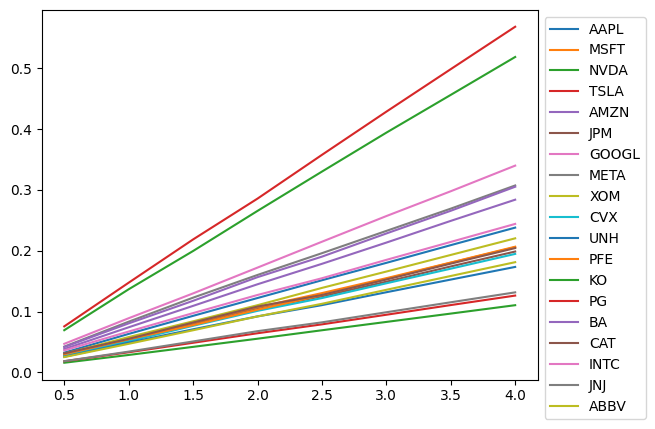

In [38]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results.AllAvg.astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

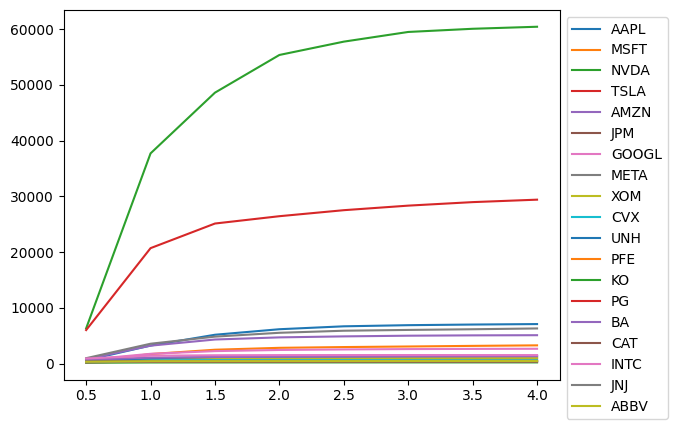

In [39]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['net%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

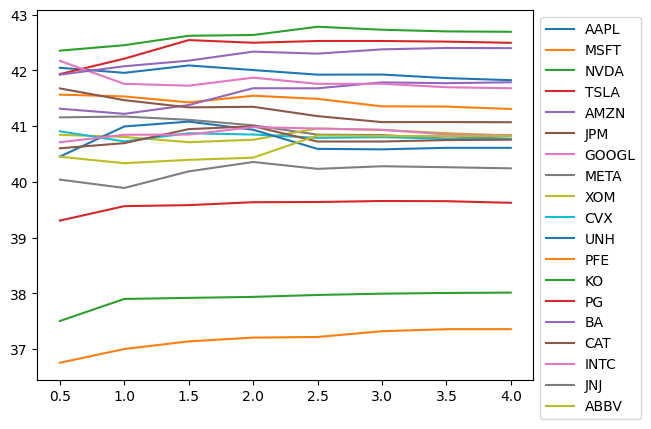

In [40]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['WR%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()